(lec5_live_dry_run)=
# Lecture 5 live coding

**2025-09-22**

---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nhanes.load import load_NHANES_data

## Pandas reassignment

If we're chaining together operations, we need to be careful about which dataframe we're modifying.

Select respondents who:

- are adults AND
- report being in `Excellent` or `Very good` health

In [15]:
nhanes_df = load_NHANES_data()

sel_df = nhanes_df[nhanes_df['AgeInYearsAtScreening'] >= 18]
sel_df = nhanes_df[(nhanes_df['GeneralHealthCondition'] == 'Excellent') | (nhanes_df['GeneralHealthCondition'] == 'Very good')]

In [16]:
print(nhanes_df.shape)
print(sel_df.shape)

(8366, 197)
(2163, 197)


`.loc` operations can be in-place:

In [17]:
print(nhanes_df['SmokedAtLeast100CigarettesInLife'].value_counts())

nhanes_df.loc[nhanes_df['GeneralHealthCondition'] == 'Excellent', 'SmokedAtLeast100CigarettesInLife'] = 0

print(nhanes_df['SmokedAtLeast100CigarettesInLife'].value_counts())

SmokedAtLeast100CigarettesInLife
0.0    3301
1.0    2232
Name: count, dtype: int64
SmokedAtLeast100CigarettesInLife
0.0    3588
1.0    2106
Name: count, dtype: int64


:::{tip}

- Restart the notebook and run from top-to-bottom to double check any reassignment issues.

- If the data are not too large, can re-run the cell to re-load the data.

:::

If there is a pandas operation that modifies portions of the dataframe, watch the `inplace` parameter!

- [fillna()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html)
- [replace()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html)

In [18]:
print(nhanes_df['SmokedAtLeast100CigarettesInLife'].isna().sum())

#nhanes_df.fillna(0)
#nhanes_df['GeneralHealthCondition'].replace({'Poor?': 'Poor', 'Fair or': 'Fair'})

2672


:::{tip}

To be safe, I generally recommend explicitly re-assigning the dataframe whenever you're modifying portions of it.

:::

# Bootstrap plotting

## The normal distribution

A probability distribution that we will frequently encounter in addition to the categorical distributions we saw in worksheet 1 is the **normal distribution**. The normal distribution has the following properties:

- centered and symmetric about the **mean** $\mu$ (or $E[X]$)
- spread by the **standard deviation** $\sigma$
    - the **variance** is $\sigma^2$ (or $V[X]$)

We write a random variable as $X$ that follows a normal distribution as $X \sim \mathcal{N}(\mu, \sigma^2)$.

:::{tip}

Watch whether the software you are using takes the variance or the standard deviation as input. In `numpy`, it is the standard deviation, which is different than how we write the distribution above.

:::

We can draw random samples from the normal distribution using [`numpy.random.Generator.normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html):

In [19]:
# This creates a generator with a fixed seed, so we can generate the same random numbers
rng = np.random.default_rng(seed=42)

# generate 50000 samples from a normal distribution with E[X]=10 and standard deviation 2
n_samples = 50000
goose_samples = rng.normal(loc=10, scale=2, size=n_samples)

In [20]:
goose_samples

array([10.60943416,  7.92003179, 11.50090239, ..., 10.79698367,
       12.71654278, 12.79095192])

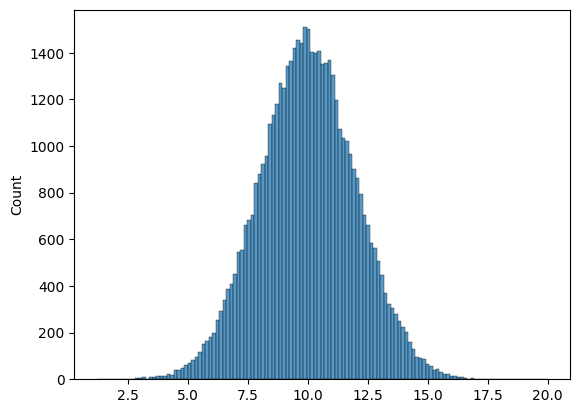

In [21]:
# Use seaborn to create a histogram of the samples
sns.histplot(goose_samples);

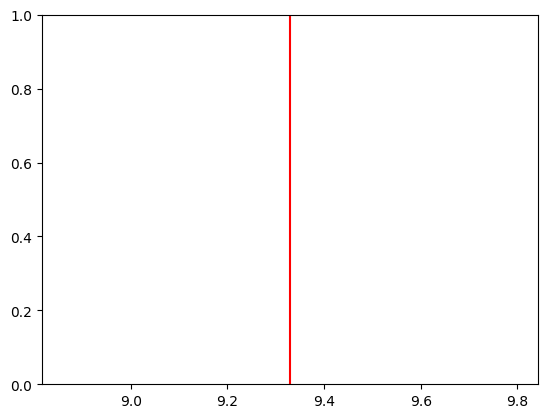

In [25]:
# Make a sample of 10 from the normal distribution
sample = goose_samples[:10]
goose_mean = np.mean(sample)

# in reality, we don't have access to the "true" distribution, which is why it's commented out
#sns.histplot(goose_samples)
plt.axvline(x=goose_mean, color='red');

For bootstrap samples, we can use [random.Generator.choice()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html) with replacement to draw samples from our dataset.

In [28]:
def mean_estimator(sample):
    """
    An estimator of the expected value E[ ] of the population.


    Args:
        sample (np.array): a sample from the population

    Returns: 
        float: the mean of the sample
    """
    return np.mean(sample)


In [29]:
n_samples = 100  
true_goose_weight = 10
# in reality, we never know what the distribution actually is
goose_weights = rng.normal(loc=true_goose_weight, scale=2, size=n_samples)

In [39]:
bootstrap_means = []
n_bootstraps = 50000

for i in range(n_bootstraps):
    # 1. draw a bootstrap sample
    bootstrap_sample = rng.choice(goose_samples, size=100, replace=True)
    bootstrap_sample
    # 2. compute our mean again, with the bootstrap sample
    bootstrap_mean = mean_estimator(bootstrap_sample)

    # 3. add our bootstrap_mean to the list
    bootstrap_means.append(bootstrap_mean)

### Plotting our bootstrap estimates

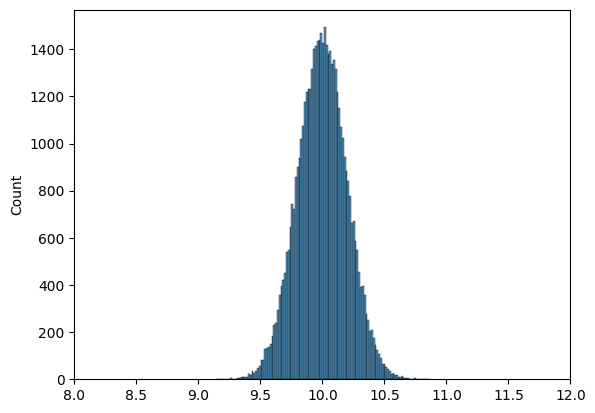

In [40]:
# plot the vertical line for the estimated mean
#plt.axvline(goose_mean, color="red")

#as our n_bootstraps increase, we're able to see the spread of the estimate
sns.histplot(bootstrap_means)
#fix the xaxis to be between 8 and 12
plt.xlim(8, 12);

## Why we care about uncertainty $\to$ confidence intervals

In [41]:
n_samples = 100  
true_goose_weight = 10
goose_weights = rng.normal(loc=true_goose_weight, scale=2, size=n_samples)

Our estimate of average goose weight: 10.1 lbs
95% Confidence Interval: [9.6, 10.4] lbs


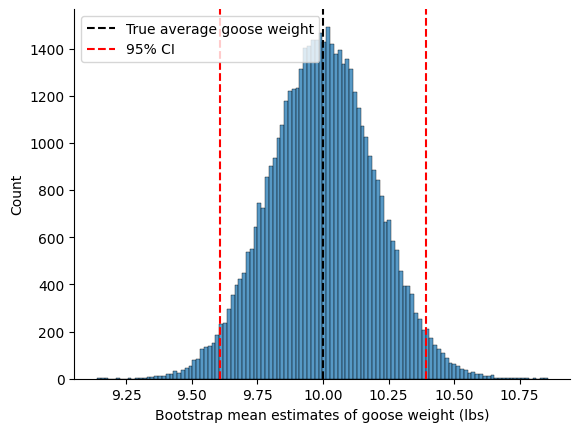

In [42]:

lower_ci = np.percentile(bootstrap_means, 2.5)
upper_ci = np.percentile(bootstrap_means, 97.5)

print(f"Our estimate of average goose weight: {mean_estimator(goose_weights):.1f} lbs")
print(f"95% Confidence Interval: [{lower_ci:.1f}, {upper_ci:.1f}] lbs")

sns.histplot(bootstrap_means)
plt.axvline(true_goose_weight, color='black', linestyle='--', label='True average goose weight')
plt.axvline(lower_ci, color='red', linestyle='--')
plt.axvline(upper_ci, color='red', linestyle='--', label='95% CI')
plt.xlabel('Bootstrap mean estimates of goose weight (lbs)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.show()


In [44]:
n_bootstraps = 1000
n_intervals = 1000

count_missed = 0

for j in range(n_intervals):
    # First draw a new sample from the true distribution
    goose_sample = rng.normal(loc=true_goose_weight, scale=2, size=100)
    
    bootstrap_means = []
    for i in range(n_bootstraps):
        # Draw bootstrap samples from this sample
        bootstrap_sample = rng.choice(goose_sample, size=100, replace=True)
        bootstrap_mean = mean_estimator(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Compute CI for this sample
    lower_ci = np.percentile(bootstrap_means, 2.5)
    upper_ci = np.percentile(bootstrap_means, 97.5)

    if true_goose_weight < lower_ci or true_goose_weight > upper_ci:
        count_missed += 1

print(f"Number of intervals that missed the true mean: {count_missed}")
print(f"Proportion of intervals that missed the true mean: {count_missed / n_intervals:.3f}")

Number of intervals that missed the true mean: 53
Proportion of intervals that missed the true mean: 0.053


### Why we care about uncertainty $\to$ comparing estimators

In [45]:
def first_ten_estimator(sample):
    """
    A (not very good) estimator of the expected value E[ ] of the population.

    Returns: 
        float: the mean of the first 10 elements of the sample
    """
    return np.mean(sample[:10])

In [49]:
bootstrap_means = []
bootstrap_first_tens = []
n_bootstraps = 50000

for i in range(n_bootstraps):
    # 1. draw a bootstrap sample
    bootstrap_sample = rng.choice(goose_weights, size=100, replace=True)
    bootstrap_sample
    
    # 2. compute our estimates, with the bootstrap sample
    bootstrap_mean = mean_estimator(bootstrap_sample)
    bootstrap_first_ten = first_ten_estimator(bootstrap_sample)
    
    # 3. add our bootstrap_mean to the list
    bootstrap_means.append(bootstrap_mean)
    bootstrap_first_tens.append(bootstrap_first_ten)

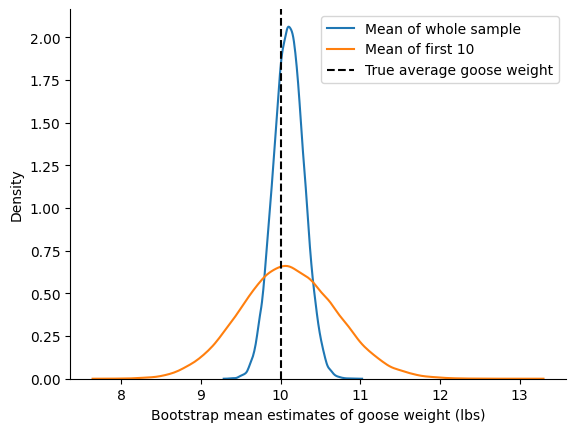

In [50]:
sns.kdeplot(bootstrap_means, label="Mean of whole sample")
sns.kdeplot(bootstrap_first_tens, label="Mean of first 10")
plt.axvline(true_goose_weight, color='black', linestyle='--', label='True average goose weight')
plt.xlabel('Bootstrap mean estimates of goose weight (lbs)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.show()
